<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase
Dataset from article: _Pyrrolamide DNA Gyrase Inhibitors: Fragment-Based Nuclear Magnetic Resonance Screening To Identify Antibacterial Agents_ Antimicrob Agents Chemother. 2012, 56(3):1240-6.


https://aac.asm.org/content/56/3/1240.long#sec-12

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [0]:
import os                # operating system interfaces 

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Visualization & graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import deepchem as dc

# Machine Learning: randomized decision trees
from sklearn.ensemble import RandomForestRegressor as RFR  
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics  import accuracy_score

from rdkit import Chem               # RDKit libraries for chemistry functions
from rdkit.Chem import Draw          # Drawing chemical structures
from rdkit.Chem import PandasTools   # Manipulating chemical data
from rdkit.Chem import Descriptors   # Calculate molecular descriptors
from rdkit.Chem import rdmolops      # Additional molecular properties
from rdkit.Chem import AllChem       # Morgan (Circular) fingerprints

from rdkit.Chem.Draw import IPythonConsole           # visualizing structures
from rdkit.ML.Descriptors import MoleculeDescriptors # molecular descriptors
from deepchem.utils.evaluate import Evaluator

Machine Learning
---------------------

Here _Random Forest_ and _Deep Neural Network_ will be used to generated a predictive model for Gyrase inhibitors $\log{\text{IC50}}$ as a function of these ligands molecular properties.


In [9]:
descriptors = ['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'MaxPartialCharge', 'MinPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'BalabanJ', 'BertzCT', 'HallKierAlpha', 'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState10', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'RingCount', 'MolLogP', 'fr_Al_COO', 'fr_Al_OH', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_C_O', 'fr_C_O_noCOO', 'fr_HOCCN', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_bicyclic', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_imidazole', 'fr_ketone', 'fr_lactam', 'fr_methoxy', 'fr_morpholine', 'fr_nitro', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_pyridine', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea']
featurizer = dc.feat.UserDefinedFeaturizer(descriptors)    # custom features
dataloader = dc.data.UserCSVLoader(tasks=["IC50"], 
                               smiles_field="Smiles", 
                               id_field="ID", 
                               featurizer=featurizer,
                               verbose=True)               # DeepChem loader class 


filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_features.csv"
deepdata = dataloader.featurize(filepath)                  # DeepChem dataset

Loading raw samples now.
shard_size: 8192
About to start loading CSV from https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_features.csv
Loading shard 1 of size 8192.
TIMING: user specified processing took 0.041 s
TIMING: featurizing shard 0 took 0.054 s
TIMING: dataset construction took 0.187 s
Loading dataset from disk.


/usr/local/lib/python3.6/site-packages/deepchem/data/data_loader.py:126: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X_shard = df.as_matrix(columns=featurizer.feature_fields)


Split the machine-learning-ready dataset into __training__, __test__ and __validation__ subsets.

In [10]:
splitter = dc.splits.RandomSplitter(deepdata)                                       
train, valid, test = splitter.train_valid_test_split(deepdata,
                                                     frac_train=.7,
                                                     frac_valid=.1,
                                                     frac_test =.2)

Computing train/valid/test indices
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data, neural networks mostly. Here we will normalize the features and $\log{\text{IC50}}$ to have zero-mean and unit-standard-deviation, using `deepchem`.

In [11]:
transformers = [
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train)]

for dataset in [train, valid, test]:
    for transformer in transformers:
        dataset = transformer.transform(dataset)

TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.007 s
Loading dataset from disk.
TIMING: dataset construction took 0.009 s
Loading dataset from disk.


### Random Forest

Fit the RF model using the training set

In [0]:
sklearn_model = RFR(n_estimators=100)
model = dc.models.SklearnModel(sklearn_model)
model.fit(train)

Evaluate the model on the __test__ set using the Mean-Squared Error and $R^2$ scores of the predictions against the target values.

In [0]:
%%capture

# MSE
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
train_scores = model.evaluate(train, [metric], transformers)
test_scores  = model.evaluate(test,  [metric], transformers)

In [14]:
print("MSE train scores {}".format(train_scores['mean_squared_error']))
print("MSE test  scores {}".format(test_scores['mean_squared_error']))

MSE train scores 2.017737395130897
MSE test  scores 12.477390933620446


In [0]:
%%capture

# R2
metric = dc.metrics.Metric(dc.metrics.r2_score)
train_scores = model.evaluate(train, [metric], transformers)
test_scores  = model.evaluate(test,  [metric], transformers)

In [16]:
print("R2 train scores {}".format(train_scores['r2_score']))
print("R2 test  scores {}".format(test_scores['r2_score']))

R2 train scores 0.937358728695096
R2 test  scores 0.5637478101279899


In [17]:
def rf_model_builder(model_params, model_dir):
    sklearn_model = RFR(**model_params)
    return dc.models.SklearnModel(sklearn_model, model_dir)

params_dict = {
    "n_estimators": [20, 100],
    "max_features": ["auto", "log2", None],
    "n_jobs": [2]
}


metric    = dc.metrics.Metric(dc.metrics.mean_squared_error)
optimizer = dc.hyper.HyperparamOpt(rf_model_builder)

best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train, test, transformers, metric=metric)

Fitting model 1/6
hyperparameters: {'n_estimators': 20, 'max_features': 'auto', 'n_jobs': 2}
computed_metrics: [13.608358121736323]
Model 1/6, Metric mean_squared_error, Validation set 0: 13.608358
	best_validation_score so far: 13.608358
Fitting model 2/6
hyperparameters: {'n_estimators': 20, 'max_features': 'log2', 'n_jobs': 2}
computed_metrics: [13.198942314365796]
Model 2/6, Metric mean_squared_error, Validation set 1: 13.198942
	best_validation_score so far: 13.608358
Fitting model 3/6
hyperparameters: {'n_estimators': 20, 'max_features': None, 'n_jobs': 2}
computed_metrics: [13.049284939874985]
Model 3/6, Metric mean_squared_error, Validation set 2: 13.049285
	best_validation_score so far: 13.608358
Fitting model 4/6
hyperparameters: {'n_estimators': 100, 'max_features': 'auto', 'n_jobs': 2}
computed_metrics: [12.960832182177182]
Model 4/6, Metric mean_squared_error, Validation set 3: 12.960832
	best_validation_score so far: 13.608358
Fitting model 5/6
hyperparameters: {'n_estima

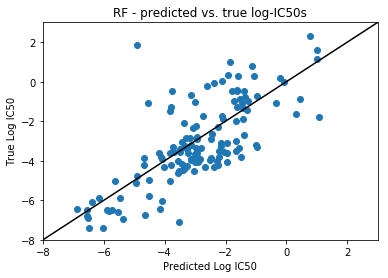

In [24]:
# Correlation plot

predicted_test = best_rf.predict(test)
true_test = test.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted Log IC50')
plt.ylabel('True Log IC50')
plt.title(r'RF - predicted vs. true log-IC50s')
plt.plot([-8, 3], [-8, 3], color='k')
plt.xlim([-8, 3])
plt.ylim([-8, 3])
plt.show()